In [1]:
import sys
sys.path.append('../../')

from dl.data.txtdetn import datasets, utils, target_transforms, augmentations
from dl.data import transforms
from dl.models.fots import FOTSRes50
from dl.loss.fots import FOTSLoss

from dl.log import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
from torch.optim.lr_scheduler import MultiStepLR

import numpy as np
%matplotlib notebook

In [2]:
augmentation = augmentations.Compose([
        augmentations.RandomLongerResize(smin=640, smax=2560),
        augmentations.RandomRotate(fill_rgb=(103.939, 116,779, 123.68), amin=-10, amax=10, same=True),
        augmentations.RandomScaleV(smin=0.8, smax=1.2, keep_aspect=True),
        augmentations.RandomSimpleCrop()
    ])

ignore = target_transforms.Ignore(strange=True, difficult=True)

transform = transforms.Compose(
    [transforms.Resize((640, 640)),
     transforms.ToTensor(),
     transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Text2Number(class_labels=datasets.SynthText_char_labels_without_upper_blank, ignore_nolabel=False),
     target_transforms.ToTensor(textTensor=True)]
)


train_dataset = datasets.Compose(
    datasets=(datasets.ICDAR2015TextDataset, datasets.ICDARBornDigitalTextDataset, datasets.ICDARFocusedSceneTextDataset),
    ignore=ignore, transform=transform, target_transform=target_transform, augmentation=augmentation
)

train_loader = DataLoader(train_dataset,
                          batch_size=8,
                          shuffle=True,
                          collate_fn=utils.batch_ind_fn,
                          num_workers=4,
                          pin_memory=True)

model = FOTSRes50(chars=datasets.SynthText_char_labels_without_upper_blank, input_shape=(None, None, 3), feature_height=8).cuda()
model.load_weights('../../weights/fots-res50/fots-pretrain_model_e10.pth')
print(model)


160 is from 640/4


FOTSRes50(
  (feature_extractor): SharedConvRes50(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (res2): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)

INFO:root:Created directory: /home/kado/weights/fots-icdar2013+15
INFO:root:Created directory: /home/kado/weights/fots-icdar2013+15/checkpoints


<IPython.core.display.Javascript object>


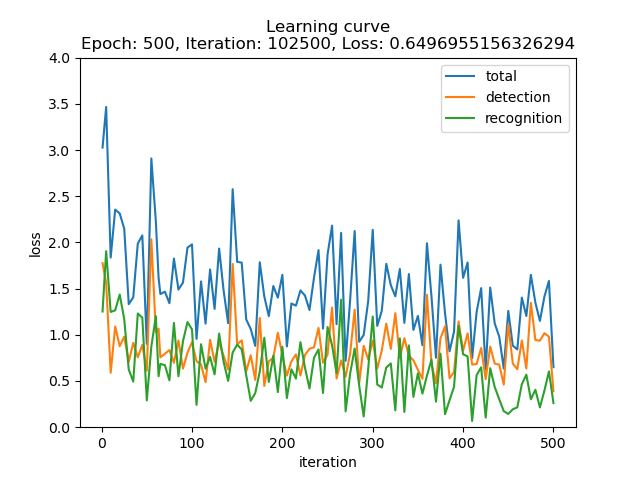

Training... Epoch: 49, Iter: 10250,	 0%[0/205]	total: 0.901630 detection: 0.611939 recognition: 0.289692 	Iter time: 0.45104450
Saved model to /home/kado/weights/fots-icdar2013+15/checkpoints/e-0000050_checkpoints20201005.pth

Training... Epoch: 99, Iter: 20500,	 0%[0/205]	total: 1.978271 detection: 0.919503 recognition: 1.058769 	Iter time: 0.46675896
Saved model to /home/kado/weights/fots-icdar2013+15/checkpoints/e-0000100_checkpoints20201005.pth

Training... Epoch: 149, Iter: 30750,	 0%[0/205]	total: 1.789787 detection: 0.896600 recognition: 0.893187 	Iter time: 0.42914839
Saved model to /home/kado/weights/fots-icdar2013+15/checkpoints/e-0000150_checkpoints20201005.pth

Training... Epoch: 199, Iter: 41000,	 0%[0/205]	total: 1.649343 detection: 0.778190 recognition: 0.871153 	Iter time: 0.38825595
Saved model to /home/kado/weights/fots-icdar2013+15/checkpoints/e-0000200_checkpoints20201005.pth

Training... Epoch: 249, Iter: 51250,	 0%[0/205]	total: 1.868539 detection: 0.784325 recogn

INFO:root:Saved model to /home/kado/weights/fots-icdar2013+15/fots-icdar2013+15_model_e-500.pth



Saved model to /home/kado/weights/fots-icdar2013+15/checkpoints/e-0000500_checkpoints20201005.pth




INFO:root:Saved optimizer to /home/kado/weights/fots-icdar2013+15/fots-icdar2013+15_optimizer_e-500.pth
INFO:root:Saved scheduler to /home/kado/weights/fots-icdar2013+15/fots-icdar2013+15_scheduler_e-500.pth


<IPython.core.display.Javascript object>


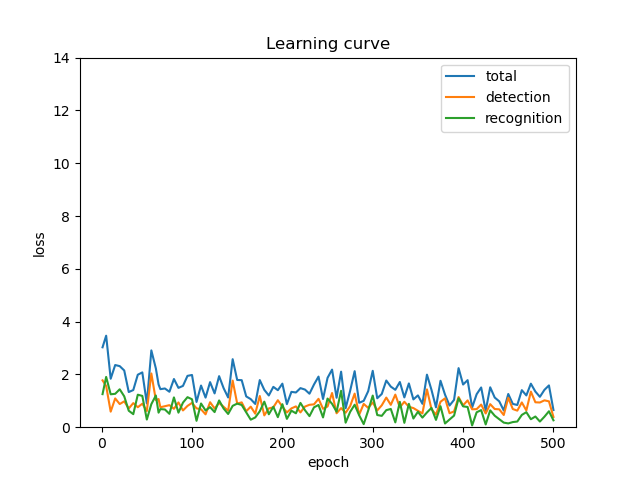

Saved graph to /home/kado/weights/fots-icdar2013+15/fots-icdar2013+15_learning-curve_e-500.png


In [3]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
epoch_scheduler = MultiStepLR(optimizer, milestones=np.arange(100, 500, 100), gamma=0.94)


save_manager = SaveManager(modelname='fots-icdar2013+15', interval=50, max_checkpoints=20, plot_interval=5)

trainer = TrainTextSpottingJupyterLogger(LiveGraph(yrange=(0, 4)), FOTSLoss(), model, optimizer, scheduler=epoch_scheduler)#iter_sheduler)
trainer.train_epoch(save_manager, 500, train_loader)
#trainer.train_iter(save_manager, 1073440, train_loader)